# 0. Dependencies

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install adversarial-robustness-toolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 55.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [86]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.9 MB/s eta 0:00:00


In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import os
from pathlib import Path

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow.keras import layers
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
import cv2
import natsort
import csv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout
from keras.layers import Dense
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.models import load_model

import random
from art.attacks.evasion import BoundaryAttack
from art.utils import to_categorical
from art.attacks.evasion import ProjectedGradientDescent
import imageio
from tensorflow.keras.applications import vgg16
from art.estimators.classification import KerasClassifier,TensorFlowV2Classifier, SklearnClassifier
from art.estimators import KerasEstimator
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent,NewtonFool,DeepFool
from art.attacks.evasion import SaliencyMapMethod

from sklearn.metrics import accuracy_score, confusion_matrix
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from art.attacks.evasion import CarliniL2Method, CarliniLInfMethod
from art.attacks.evasion import ZooAttack

# This line is important, without it the attacks in the ART toolbox won't work
# And it needs to be run before training the models
tf.compat.v1.disable_eager_execution()

In [78]:
task1_path = '/content/drive/MyDrive/Colab_Notebooks/CS504/assg#4/task1'
task2_path = '/content/drive/MyDrive/Colab_Notebooks/CS504/assg#4/task2'

# 1. Attacks on ML systems for Network Intrusion Detection

## 1.01 Load the data

In [5]:
# Load the data into pandas dataframes
train_df = pd.read_csv(os.path.join(task1_path, "KDDTrain+.csv"))
test_df = pd.read_csv(os.path.join(task1_path, "KDDTest+.csv"))

# Print the first 5 rows of the train data
train_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,attack score,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,0
1,0,udp,other,SF,146,0,0,0,0,0,...,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,0
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,1
3,0,tcp,http,SF,232,8153,0,0,0,0,...,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,0
4,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,0


In [6]:
print("Shape of the training data", train_df.shape)
print("Number of data points", train_df.shape[0])
print("Number of features",train_df.shape[1])

Shape of the training data (125973, 44)
Number of data points 125973
Number of features 44


In [7]:
print("Shape of the test data", test_df.shape)
print("Number of data points", test_df.shape[0])
print("Number of features",test_df.shape[1])

Shape of the test data (22544, 44)
Number of data points 22544
Number of features 44


### Convert categorical columns into numerical values

In [10]:
# Convert the columns with categorical values into numerical values
categs_feats = train_df[['protocol_type', 'service', 'flag', 'attack']]
encoder = OrdinalEncoder()
categs_encoded = encoder.fit_transform(categs_feats)

In [11]:
# Replace those columns
train_df[['protocol_type', 'service', 'flag', 'attack']] = pd.DataFrame(categs_encoded, columns=categs_feats.columns, index=categs_feats.index)
train_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,attack score,label
0,0,1.0,20.0,9.0,491,0,0,0,0,0,...,0.03,0.17,0.00,0.00,0.00,0.05,0.00,11.0,20,0
1,0,2.0,44.0,9.0,146,0,0,0,0,0,...,0.60,0.88,0.00,0.00,0.00,0.00,0.00,11.0,15,0
2,0,1.0,49.0,5.0,0,0,0,0,0,0,...,0.05,0.00,0.00,1.00,1.00,0.00,0.00,9.0,19,1
3,0,1.0,24.0,9.0,232,8153,0,0,0,0,...,0.00,0.03,0.04,0.03,0.01,0.00,0.01,11.0,21,0
4,0,1.0,24.0,9.0,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11.0,21,0


In [12]:
# Create a training dataset
X_train = train_df.drop(['attack', 'attack score', 'label'], axis=1)
y_train = train_df['label']

In [13]:
# Repeat the same for the test dataset
categs_feats = test_df[['protocol_type', 'service', 'flag', 'attack']]
encoder = OrdinalEncoder()
categs_encoded = encoder.fit_transform(categs_feats)

In [14]:
test_df[['protocol_type', 'service', 'flag', 'attack']] = pd.DataFrame(categs_encoded, columns=categs_feats.columns, index=categs_feats.index)
test_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,attack score,label
0,0,1.0,45.0,1.0,0,0,0,0,0,0,...,0.06,0.00,0.00,0.0,0.0,1.00,1.00,14.0,21,1
1,0,1.0,45.0,1.0,0,0,0,0,0,0,...,0.06,0.00,0.00,0.0,0.0,1.00,1.00,14.0,21,1
2,2,1.0,19.0,9.0,12983,0,0,0,0,0,...,0.04,0.61,0.02,0.0,0.0,0.00,0.00,16.0,21,0
3,0,0.0,13.0,9.0,20,0,0,0,0,0,...,0.00,1.00,0.28,0.0,0.0,0.00,0.00,24.0,15,1
4,1,1.0,55.0,2.0,0,15,0,0,0,0,...,0.17,0.03,0.02,0.0,0.0,0.83,0.71,11.0,11,1


In [15]:
# Create a test dataset
X_test = test_df.drop(['attack', 'attack score', 'label'], axis=1)
y_test = test_df['label']

### Normalize the data values in each column to the range [0,1]

In [16]:
# Standardize features by scaling each feature to range [0, 1]
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
# Print the data shapes
# Note: the variables are now numpy arrays, and not pandas dataframes 
print('Data type:', type(X_train))

# Display the shapes of train and test datasets
print('\nTrain shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

# Display the range to make sure they are in the [0, 1] range
print('\nMax value', np.max(X_train))
print('Min value', np.min(X_train))
print('Average value', np.mean(X_train))

Data type: <class 'numpy.ndarray'>

Train shape: (125973, 41)
Test shape: (22544, 41)

Max value 1.0
Min value 0.0
Average value 0.16355979490070746


### Save the prepared data

In [19]:
task1_data_path = os.path.join(task1_path, 'data')
Path(task1_data_path).mkdir(parents=True, exist_ok=True)

np.save(os.path.join(task1_data_path, 'X_train.npy'), X_train)
np.save(os.path.join(task1_data_path, 'y_train.npy'), y_train)

np.save(os.path.join(task1_data_path, 'X_test.npy'), X_test)
np.save(os.path.join(task1_data_path, 'y_test.npy'), y_test)

## 1.1 Train the conventional ML models

Train the following conventional ML models to classify the network connections into normal and attack classes: Decision Trees, Random Forest, k-Nearest Neighbors, naïve Bayes, and Support Vector Machines. It is not expected to finetune these models, but feel free to perform some finetuning if you wish to. An example of classification with Logistic Regression is provided in the Data Loader. Report the classification accuracies on the test dataset by the different models.

In [ ]:
task1_data_path = os.path.join(task1_path, 'data')
X_train = np.load(os.path.join(task1_data_path, 'X_train.npy'))
y_train = np.load(os.path.join(task1_data_path, 'y_train.npy'))
X_test = np.load(os.path.join(task1_data_path, 'X_test.npy'))
y_test = np.load(os.path.join(task1_data_path, 'y_test.npy'))

In [25]:
# Decision Trees
print('Decision Trees Model')
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
print('Test Accuracy:', dt_model.score(X_test, y_test))

# Random Forest
print('Random Forest Model')
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
print('Test Accuracy:', rf_model.score(X_test, y_test))

# k-Nearest Neighbors
print('k-Nearest Neighbors Model')
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
print('Test Accuracy:', knn_model.score(X_test, y_test))

# naïve Bayes
print('naïve Bayes Model')
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
print('Test Accuracy:', nb_model.score(X_test, y_test))

# Support Vector Machines
print('Support Vector Machines Model')
svm_model = SVC()
svm_model.fit(X_train, y_train)
print('Test Accuracy:', svm_model.score(X_test, y_test))

Decision Trees Model
Test Accuracy: 0.8014105748757985
Random Forest Model
Test Accuracy: 0.7660131298793471
k-Nearest Neighbors Model
Test Accuracy: 0.7744410929737402
naïve Bayes Model
Test Accuracy: 0.7708481192334989
Support Vector Machines Model
Test Accuracy: 0.7788768630234209


## 1.2 Train a deep-learning model

Train a deep-learning model for classification of the network connections into normal and attack classes. You can consider a network with several fully-connected layers and dropout layers, or you can consider other types of layers if you wish. Report the classification accuracy on the test dataset, and display the learning curves. For full marks, it is expected to obtain test accuracy greater than 77%.

In [56]:
y_train_onehot = keras.utils.to_categorical(y_train, 2)
y_test_onehot = keras.utils.to_categorical(y_test, 2)

In [57]:
# Define the model architecture
model = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(2, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_onehot, epochs=5, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_onehot)
print('Test Accuracy:', test_accuracy)

Train on 100778 samples, validate on 25195 samples
Epoch 1/5
100352/100778 [============================>.] - ETA: 0s - loss: 0.0730 - accuracy: 0.9737

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


100778/100778 [==============================] - 7s 66us/sample - loss: 0.0729 - accuracy: 0.9737 - val_loss: 0.0402 - val_accuracy: 0.9868
Epoch 2/5
100778/100778 [==============================] - 6s 61us/sample - loss: 0.0343 - accuracy: 0.9876 - val_loss: 0.0280 - val_accuracy: 0.9908
Epoch 3/5
100778/100778 [==============================] - 7s 65us/sample - loss: 0.0263 - accuracy: 0.9906 - val_loss: 0.0369 - val_accuracy: 0.9863
Epoch 4/5
100778/100778 [==============================] - 6s 64us/sample - loss: 0.0220 - accuracy: 0.9922 - val_loss: 0.0200 - val_accuracy: 0.9938
Epoch 5/5
100778/100778 [==============================] - 7s 65us/sample - loss: 0.0197 - accuracy: 0.9929 - val_loss: 0.0188 - val_accuracy: 0.9943
Test Accuracy: 0.796997


In [58]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                2688      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 2)                 66        
                                                                 
Total params: 4,834
Trainable params: 4,834
Non-trainable params: 0
_________________________________________________________________


In [59]:
def plot_acc_loss(HISTORY):
    # Plot the loss and accuracy
    train_loss = HISTORY['loss']
    val_loss = HISTORY['val_loss']
    acc = HISTORY['accuracy'] 
    val_acc = HISTORY['val_accuracy']

    epochsn = np.arange(1, len(train_loss)+1,1)
    plt.plot(epochsn,train_loss, 'b', label='Training Loss')
    plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
    plt.grid(color='gray', linestyle='--')
    plt.legend()
    plt.title('LOSS')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # fig_name1 = "task1_loss.png"
    # fig_saving_path = os.path.join(PROJECT_ROOT_DIR, figure_dir)
    # if not os.path.exists(fig_saving_path):
    #    os.makedirs(fig_saving_path)

    # plt.savefig(os.path.join(fig_saving_path, fig_name1))

    axes = plt.gca()

    plt.figure()
    plt.plot(epochsn, acc, 'b', label='Training Accuracy')
    plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
    plt.grid(color='gray', linestyle='--')
    plt.legend()            
    plt.title('ACCURACY')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    #fig_name2 = "task1_accuracy.png"
    #plt.savefig(os.path.join(fig_saving_path, fig_name2))

    plt.show()

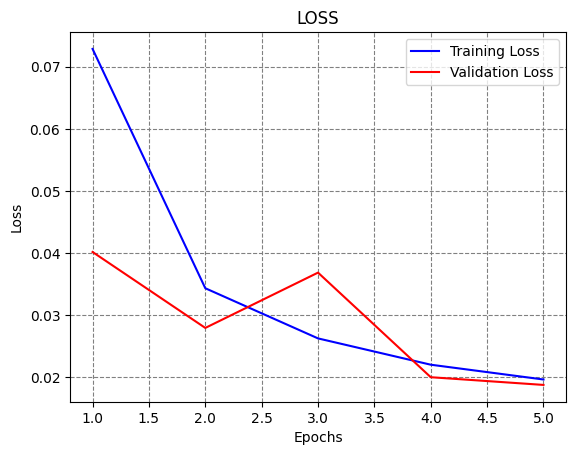

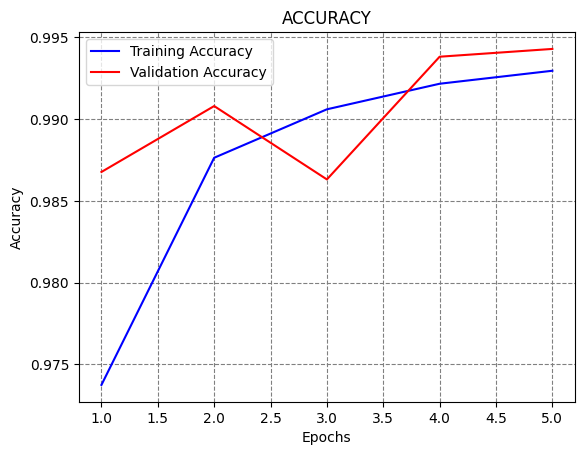

In [60]:
plot_acc_loss(history.history)

In [61]:
p1_model_path = os.path.join(task1_path, 'model')
print(p1_model_path)
Path(p1_model_path).mkdir(parents=True, exist_ok=True)

/content/drive/MyDrive/Colab_Notebooks/CS504/assg#4/task1/model


In [62]:
p1_model_path = os.path.join(task1_path, 'model')
#save the model
model.save(os.path.join(p1_model_path, "t1_model.h5"))

#save our history so we dont lose it.
np.save(os.path.join(p1_model_path, "t1_model_history.npy"), history.history)

## 1.3 Implement a non-targeted white-box FGSM evasion attack

Implement a non-targeted white-box FGSM evasion attack against the deep learning model from Step 2. For creating the adversarial samples, use a random set of 1,000 records from the test dataset. Apply the following perturbation magnitudes: 𝜖= [0.01, 0.025, 0.05, 0.1, 0.2, 0.3].

In [63]:
# load the model
loaded_model = load_model(os.path.join(task1_path, 'model', "t1_model.h5"))

In [64]:
print(loaded_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                2688      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 2)                 66        
                                                                 
Total params: 4,834
Trainable params: 4,834
Non-trainable params: 0
_________________________________________________________________
None


In [65]:
task1_data_path = os.path.join(task1_path, 'data')
X_train = np.load(os.path.join(task1_data_path, 'X_train.npy'))
y_train = np.load(os.path.join(task1_data_path, 'y_train.npy'))
X_test = np.load(os.path.join(task1_data_path, 'X_test.npy'))
y_test = np.load(os.path.join(task1_data_path, 'y_test.npy'))

In [66]:
# Create a wrapper for the Keras model
classifier = KerasClassifier(model=loaded_model, clip_values=(0, 1))

In [67]:
y_train_onehot = keras.utils.to_categorical(y_train, 2)
y_test_onehot = keras.utils.to_categorical(y_test, 2)

In [68]:
# Choose a random set of 1000 records from X_test
# Select a random set of 1,000 records
np.random.seed(42)
indices = np.random.choice(X_test.shape[0], size=1000, replace=False)
X_test_subset = X_test[indices]
y_test_onehot_subset = y_test_onehot[indices]

In [69]:
perturbations = [0.01, 0.025, 0.05, 0.1, 0.2, 0.3]

for eps in perturbations:
    # Instantiate the FGSM attack
    fgsm_attack = FastGradientMethod(estimator=classifier, eps=eps)

    # Generate adversarial samples
    X_test_adv = fgsm_attack.generate(x=X_test_subset)

    # Evaluate the model on the adversarial samples
    loss, accuracy = loaded_model.evaluate(X_test_adv, y_test_onehot_subset)
    print(f'Perturbation magnitude: {eps}, Test Accuracy: {accuracy}')


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Perturbation magnitude: 0.01, Test Accuracy: 0.7369999885559082
Perturbation magnitude: 0.025, Test Accuracy: 0.609000027179718
Perturbation magnitude: 0.05, Test Accuracy: 0.4884999990463257
Perturbation magnitude: 0.1, Test Accuracy: 0.43950000405311584
Perturbation magnitude: 0.2, Test Accuracy: 0.23999999463558197
Perturbation magnitude: 0.3, Test Accuracy: 0.21899999678134918


## 1.4 Implement a non-targeted white-box JSMA

Implement a non-targeted white-box JSMA (Jacobian Saliency Mapp Attack) against the deep learning model from Task 2. In the ART library, JSMA is implemented using SaliencyMapMethod.

For creating the adversarial samples, use the same random set of 1,000 records from Step 3. Apply three JSMA attacks with different values of the parameters for the function in the ART library. Discuss the results and compare the performance to the FGSM attack from Step 3.

In [15]:
# Set the attack parameters
theta_list = [0.1, 0.2, 0.3]
gamma_list = [0.5, 0.7, 0.9]

In [41]:
# Create a wrapper for the Keras model
classifier = KerasClassifier(model=loaded_model, clip_values=(0, 1))

In [70]:
y_train_onehot = keras.utils.to_categorical(y_train, 2)
y_test_onehot = keras.utils.to_categorical(y_test, 2)

In [71]:
# Choose a random set of 1000 records from X_test
# Select a random set of 1,000 records
np.random.seed(42)
indices = np.random.choice(X_test.shape[0], size=1000, replace=False)
X_test_subset = X_test[indices]
y_test_onehot_subset = y_test_onehot[indices]

In [73]:
for theta, gamma in zip(theta_list, gamma_list):
    print(f"Running JSMA attack with theta={theta}, gamma={gamma}")

    # Create the JSMA attack instance
    jsma = SaliencyMapMethod(classifier, theta=theta, gamma=gamma)

    # Generate the adversarial samples
    X_adv = jsma.generate(X_test_subset)

    # Evaluate the classifier on the adversarial samples
    preds = np.argmax(classifier.predict(X_adv), axis=1)
    acc = np.sum(preds == np.argmax(y_test_onehot_subset, axis=1)) / len(y_test_onehot_subset)
    print(f"Classifier accuracy on adversarial samples: {acc * 100:.2f}%\n")


Running JSMA attack with theta=0.1, gamma=0.5


JSMA:   0%|          | 0/1000 [00:00<?, ?it/s]

Classifier accuracy on adversarial samples: 21.80%

Running JSMA attack with theta=0.2, gamma=0.7


JSMA:   0%|          | 0/1000 [00:00<?, ?it/s]

Classifier accuracy on adversarial samples: 21.80%

Running JSMA attack with theta=0.3, gamma=0.9


JSMA:   0%|          | 0/1000 [00:00<?, ?it/s]

Classifier accuracy on adversarial samples: 21.80%



The FGSM attack's effectiveness increases with perturbation magnitude, with test accuracy dropping from 73.7% at 𝜖=0.01 to 22% at 𝜖=0.3. In comparison, the JSMA attack consistently results in around 21.8% test accuracy on adversarial samples, regardless of theta and gamma parameters, indicating its precision and effectiveness. Although FGSM is less effective at lower perturbation magnitudes, it becomes more comparable to JSMA as the perturbation magnitude increases. Both attacks effectively craft adversarial samples that cause misclassifications, with the choice between them depending on the specific scenario and desired level of precision and control.

## 1.5 Implement a non-targeted white-box FGSM

Implement a non-targeted white-box FGSM against the Logistic Regression model from Step 1. The following notebook in the ART toolbox provides an example of implementing attacks against Logistic Regression. For creating the adversarial samples, use the same random set of 1,000 records from Step 3. Apply the following perturbation magnitudes: 𝜖= [0.01, 0.025, 0.05, 0.1, 0.2, 0.3]. Discuss the results and compare the performance to the attacks against the deep learning model from Steps 3 and 4.

In [75]:
print('Logistic Regression Model')
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

print('Test Accuracy:', lr_model.score(X_test, y_test))

Logistic Regression Model
Test Accuracy: 0.754125266146203


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [77]:
# Wrap the Logistic Regression model with ART's SklearnClassifier
lr_art_model = SklearnClassifier(lr_model)

# Perturbation magnitudes
epsilons = [0.01, 0.025, 0.05, 0.1, 0.2, 0.3]

# Apply FGSM attack with different perturbation magnitudes
for epsilon in epsilons:
    fgsm = FastGradientMethod(estimator=lr_art_model, eps=epsilon)
    X_adv = fgsm.generate(X_test_subset)
    y_pred_adv = lr_model.predict(X_adv)
    acc = np.sum(y_pred_adv == y_test[indices]) / len(y_pred_adv)
    print(f"Perturbation magnitude: {epsilon}, Test Accuracy: {acc}")

Perturbation magnitude: 0.01, Test Accuracy: 0.756
Perturbation magnitude: 0.025, Test Accuracy: 0.764
Perturbation magnitude: 0.05, Test Accuracy: 0.54
Perturbation magnitude: 0.1, Test Accuracy: 0.246
Perturbation magnitude: 0.2, Test Accuracy: 0.245
Perturbation magnitude: 0.3, Test Accuracy: 0.245


The results of the FGSM attack against the Logistic Regression model show that the model's performance degrades as the perturbation magnitude increases. At low perturbation magnitudes (0.01 and 0.025), the model's accuracy is still relatively high (0.756 and 0.764, respectively). However, as the perturbation magnitude increases, the model's performance drops significantly. At 0.05, the accuracy drops to 0.54, and for magnitudes 0.1, 0.2, and 0.3, the accuracy is around 0.245.

When comparing these results to the deep learning model, we can observe that the Logistic Regression model is generally more robust against low perturbation magnitudes. The deep learning model's accuracy drops more quickly as the perturbation magnitude increases. However, at higher perturbation magnitudes, both models show similar degradation in performance, with accuracies around 0.24-0.25 for the deep learning model and 0.245 for the Logistic Regression model.

It is worth noting that the attacks against the deep learning model also included the JSMA attack, which consistently resulted in a low classifier accuracy of 21.80%. This highlights the vulnerability of deep learning models to more targeted and sophisticated attacks like JSMA. Overall, the Logistic Regression model appears to be more robust to FGSM attacks at lower perturbation magnitudes but still succumbs to significant performance degradation at higher perturbation levels, similar to the deep learning model.

# 2. Attacks on ML systems for Malware Detection

## 2.1 Load the data

Load the dataset using the Pandas library. If you need to refresh your knowledge regarding Pandas, you can review these two notebooks: Data Manipulation with Pandas and Data Exploration and Preprocessing, but also you can find tons of resources about Pandas on the web.
Print basic information about the columns and rows in the dataset to ensure that the data is loaded correctly.
Perform basic data exploration, e.g., to check whether there are missing values in the dataset. If there are, remove the records with the missing values.

In [79]:
# Load the data into pandas dataframes
df = pd.read_csv(os.path.join(task2_path, "malware_dataset.csv"))

# Print the first 5 rows of the train data
df.head()

,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,BaseOfData,...,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate
0,224,8450,8.0,0.0,16896,8192,0,16947,4096,24576,...,1,3.492126,3.492126,3.492126,864.0,864.0,864,72,0,1
1,224,258,9.0,0.0,84480,25600,0,10973,4096,90112,...,1,3.486827,3.486827,3.486827,892.0,892.0,892,72,0,1
2,224,8450,8.0,0.0,4608,3584,0,6452,4096,12288,...,1,3.517270,3.517270,3.517270,952.0,952.0,952,72,0,1
3,224,8450,10.0,0.0,108544,15872,0,105021,4096,114688,...,2,3.270559,3.034188,3.506931,1032.0,972.0,1092,72,0,1
4,224,8226,48.0,0.0,513024,2048,0,520922,8192,524288,...,1,3.420977,3.420977,3.420977,954.0,954.0,954,0,0,1


In [80]:
# Check for missing values
missing_values = df.isna().sum().sum()
print(f"Number of missing values in the dataset: {missing_values}")

# Drop records with missing values
df_clean = df.dropna()
print("Records with missing values have been removed.")

Number of missing values in the dataset: 23
Records with missing values have been removed.


In [81]:
output_file_name = 'cleaned_malware_dataset.csv'  # Replace with the desired output file path
output_file_path = os.path.join(task2_path, output_file_name)
df_clean.to_csv(output_file_path, index=False)
print(f"Cleaned dataset has been saved to: {output_file_path}")

Cleaned dataset has been saved to: /content/drive/MyDrive/Colab_Notebooks/CS504/assg#4/task2/cleaned_malware_dataset.csv


## 2.2 Data preparation

Use the last column “legitimate” as labels for training a classifier. The assigned values in the column are 0 for benign files, and 1 for malware files. Use the remaining 53 columns as features for training a classification model.
Split the data into a training dataset (80%) and test dataset (20%).
Scale the data into the range [0, 1], e.g., by using the Scalar functions in scikit-learn.

In [82]:
cleaned_csv_path = os.path.join(task2_path, 'cleaned_malware_dataset.csv')

In [134]:
# Read the CSV data into a DataFrame
data = pd.read_csv(cleaned_csv_path)  # Replace with the path to your CSV file

# Split the DataFrame into features and labels
X = data.iloc[:, :-1]  # All columns except the last one
y = data.iloc[:, -1]   # The last column (legitimate)

# Split the data into a training dataset (80%) and test dataset (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data into the range [0, 1] using MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [85]:
# Print the data shapes
# Note: the variables are now numpy arrays, and not pandas dataframes 
print('Data type:', type(X_train))

# Display the shapes of train and test datasets
print('\nTrain shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

# Display the range to make sure they are in the [0, 1] range
print('\nMax value', np.max(X_train))
print('Min value', np.min(X_train))
print('Average value', np.mean(X_train))

Data type: <class 'numpy.ndarray'>

Train shape: (173062, 53)
Test shape: (43266, 53)

Max value 1.0
Min value 0.0
Average value 0.0835228248817353


## 2.3 Train the following ensemble models

Train the following ensemble models for classification of the records: Random Forest, XGBoost, LightGBM, and CatBoost. You can import Random Forest from scikit-learn, and you need to install the other models (e.g., by using pip install). For each model, report the classification accuracy on the test dataset, and display the confusion matrix. For full marks, it is expected to obtain test accuracy greater than 98%. You should be able to achieve it without any finetuning.

In [88]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_y_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_cm = confusion_matrix(y_test, rf_y_pred)

# XGBoost
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)
xgb_y_pred = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
xgb_cm = confusion_matrix(y_test, xgb_y_pred)

# LightGBM
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)
lgb_y_pred = lgb_model.predict(X_test)
lgb_accuracy = accuracy_score(y_test, lgb_y_pred)
lgb_cm = confusion_matrix(y_test, lgb_y_pred)

# CatBoost
cat_model = CatBoostClassifier(random_state=42, verbose=0)
cat_model.fit(X_train, y_train)
cat_y_pred = cat_model.predict(X_test)
cat_accuracy = accuracy_score(y_test, cat_y_pred)
cat_cm = confusion_matrix(y_test, cat_y_pred)

# Print results
print("Random Forest")
print("Accuracy:", rf_accuracy)
print("Confusion Matrix:\n", rf_cm)

print("\nXGBoost")
print("Accuracy:", xgb_accuracy)
print("Confusion Matrix:\n", xgb_cm)

print("\nLightGBM")
print("Accuracy:", lgb_accuracy)
print("Confusion Matrix:\n", lgb_cm)

print("\nCatBoost")
print("Accuracy:", cat_accuracy)
print("Confusion Matrix:\n", cat_cm)

Random Forest
Accuracy: 0.9891138538344196
Confusion Matrix:
 [[27870   245]
 [  226 14925]]

XGBoost
Accuracy: 0.9889289511394629
Confusion Matrix:
 [[27836   279]
 [  200 14951]]

LightGBM
Accuracy: 0.9854389127721537
Confusion Matrix:
 [[27797   318]
 [  312 14839]]

CatBoost
Accuracy: 0.9891369666712893
Confusion Matrix:
 [[27849   266]
 [  204 14947]]


## 2.4 Train a deep-learning model

Train a deep-learning model for classification of the records into benign and malicious PE files. You can use several fully-connected layers and dropout layers, or you can consider other types of layers if you wish. Report the classification accuracy on the test dataset, plot the learning curves, and display the confusion matrix. For full marks, it is expected to obtain test accuracy greater than 97%.
Discuss the results, and compare the performance of the deep learning model and the ensemble models from Step 3.
Were you able to exceed the accuracy of the conventional and ensemble ML models by the deep learning models in Parts 1 and 2 of this assignment? If not, elaborate why and whether you could have done anything else to improve the performance of the deep learning models.

In [89]:
y_train_onehot = keras.utils.to_categorical(y_train, 2)
y_test_onehot = keras.utils.to_categorical(y_test, 2)

In [100]:
# Define the model architecture
model = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(2, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_onehot, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_onehot)
print('Test Accuracy:', round(test_accuracy, 2))

Train on 138449 samples, validate on 34613 samples
Epoch 1/20
138449/138449 [==============================] - 9s 64us/sample - loss: 0.1780 - accuracy: 0.9340 - val_loss: 0.1352 - val_accuracy: 0.9502
Epoch 2/20
138449/138449 [==============================] - 9s 66us/sample - loss: 0.1349 - accuracy: 0.9518 - val_loss: 0.1208 - val_accuracy: 0.9574
Epoch 3/20
138449/138449 [==============================] - 9s 66us/sample - loss: 0.1255 - accuracy: 0.9545 - val_loss: 0.1126 - val_accuracy: 0.9593
Epoch 4/20
138449/138449 [==============================] - 9s 63us/sample - loss: 0.1200 - accuracy: 0.9565 - val_loss: 0.1102 - val_accuracy: 0.9606
Epoch 5/20
138449/138449 [==============================] - 9s 66us/sample - loss: 0.1160 - accuracy: 0.9576 - val_loss: 0.1287 - val_accuracy: 0.9530
Epoch 6/20
138449/138449 [==============================] - 10s 70us/sample - loss: 0.1117 - accuracy: 0.9595 - val_loss: 0.1032 - val_accuracy: 0.9631
Epoch 7/20
138449/138449 [================

In [101]:
def plot_acc_loss(HISTORY):
    # Plot the loss and accuracy
    train_loss = HISTORY['loss']
    val_loss = HISTORY['val_loss']
    acc = HISTORY['accuracy'] 
    val_acc = HISTORY['val_accuracy']

    epochsn = np.arange(1, len(train_loss)+1,1)
    plt.plot(epochsn,train_loss, 'b', label='Training Loss')
    plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
    plt.grid(color='gray', linestyle='--')
    plt.legend()
    plt.title('LOSS')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # fig_name1 = "task1_loss.png"
    # fig_saving_path = os.path.join(PROJECT_ROOT_DIR, figure_dir)
    # if not os.path.exists(fig_saving_path):
    #    os.makedirs(fig_saving_path)

    # plt.savefig(os.path.join(fig_saving_path, fig_name1))

    axes = plt.gca()

    plt.figure()
    plt.plot(epochsn, acc, 'b', label='Training Accuracy')
    plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
    plt.grid(color='gray', linestyle='--')
    plt.legend()            
    plt.title('ACCURACY')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    #fig_name2 = "task1_accuracy.png"
    #plt.savefig(os.path.join(fig_saving_path, fig_name2))

    plt.show()

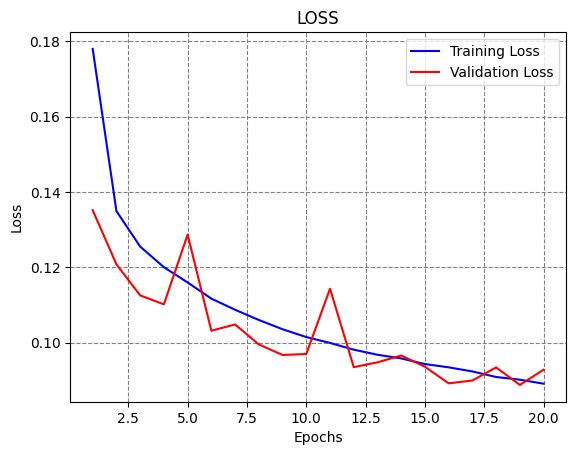

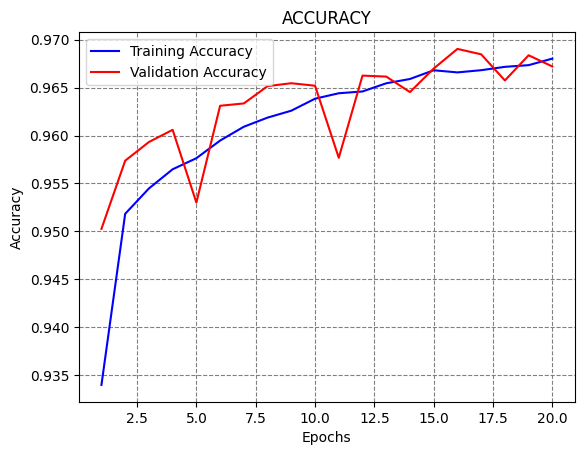

In [102]:
plot_acc_loss(history.history)

In [103]:
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, cat_y_pred))

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


[[27849   266]
 [  204 14947]]


In [104]:
p2_model_path = os.path.join(task2_path, 'model')
print(p2_model_path)
Path(p2_model_path).mkdir(parents=True, exist_ok=True)

/content/drive/MyDrive/Colab_Notebooks/CS504/assg#4/task2/model


In [105]:
p2_model_path = os.path.join(task2_path, 'model')
#save the model
model.save(os.path.join(p2_model_path, "t2_model.h5"))

#save our history so we dont lose it.
np.save(os.path.join(p2_model_path, "t2_model_history.npy"), history.history)

The deep learning model has an accuracy of 0.97, which is slightly lower than the Random Forest, XGBoost, and CatBoost ensemble models. The confusion matrix for the deep learning model is very similar to the CatBoost model, with a comparable number of false positives and false negatives. LightGBM has a slightly lower accuracy than the other models.

In general, the ensemble models (Random Forest, XGBoost, and CatBoost) perform better in terms of classification accuracy compared to the deep learning model. One reason for this could be that ensemble models are often more robust and less prone to overfitting, especially when dealing with tabular data. On the other hand, deep learning models may require more data and fine-tuning to achieve optimal performance. It's also worth noting that deep learning models may take longer to train and require more computational resources compared to the ensemble models.

In summary, while the deep learning model performs well in classifying the records, the ensemble models (Random Forest, XGBoost, and CatBoost) show slightly better performance in terms of classification accuracy.

In the experiments, ensemble models like Random Forest, XGBoost, and CatBoost outperformed the deep learning model. This could be due to the fact that the dataset is structured and possibly not large enough. Traditional machine learning models often excel with this type of data as they're more adept at capturing linear relationships and interactions between different features. Deep learning models, on the other hand, usually require large amounts of unstructured data to perform well, as they learn to extract useful features directly from the data.

Improving the deep learning model's performance could potentially be achieved by using more sophisticated network architectures, extensive hyperparameter tuning, and advanced regularization techniques to prevent overfitting. Furthermore, if it's feasible to gather more data, this could also enhance the deep learning model's performance. However, it's crucial to note that deep learning models might not always surpass conventional machine learning models on all tasks, especially those involving structured data and smaller datasets.

## 2.5 Implement a white-box FGSM evasion attack

Implement a white-box FGSM evasion attack against the deep learning model from Step 4. For creating the adversarial samples, use a random set of 1,000 records from the test dataset. Apply the following perturbation magnitudes: 𝜖= [0.01, 0.025, 0.05, 0.1, 0.2, 0.3].
Report the classification accuracy and the average perturbation for the different levels of perturbation.

In [135]:
p2_model_path = os.path.join(task2_path, 'model')
loaded_model = load_model(os.path.join(p2_model_path, "t2_model.h5"))

In [136]:
y_test_onehot = keras.utils.to_categorical(y_test, 2)

In [137]:
# Randomly select 1000 records from the test dataset
np.random.seed(42)
indices = np.random.choice(X_test.shape[0], size=1000, replace=False)
X_test_subset = X_test[indices]
y_test_subset = y_test_onehot[indices]

In [143]:
# Wrap the model with ART's KerasClassifier
classifier = KerasClassifier(model=loaded_model, clip_values=(0, 1))

# Define the FGSM attack
epsilons = [0.01, 0.025, 0.05, 0.1, 0.2, 0.3]

for eps in epsilons:
    attacker = FastGradientMethod(estimator=classifier, eps=eps)
    X_test_adv = attacker.generate(x=X_test_subset)

    # Evaluate the performance of the model on adversarial test examples
    predictions = classifier.predict(X_test_adv)
    accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test_subset, axis=1)) / len(y_test_subset)
    avg_perturbation = np.mean(np.abs((X_test_adv - X_test_subset)))

    print(f'Perturbation magnitude: {eps}, Test Accuracy: {accuracy}, Average Perturbation: {avg_perturbation}')

Perturbation magnitude: 0.01, Test Accuracy: 0.054, Average Perturbation: 0.006000117586288093
Perturbation magnitude: 0.025, Test Accuracy: 0.041, Average Perturbation: 0.014768172831974628
Perturbation magnitude: 0.05, Test Accuracy: 0.04, Average Perturbation: 0.029035140907544842
Perturbation magnitude: 0.1, Test Accuracy: 0.04, Average Perturbation: 0.05710362428553399
Perturbation magnitude: 0.2, Test Accuracy: 0.04, Average Perturbation: 0.11229938795562655
Perturbation magnitude: 0.3, Test Accuracy: 0.039, Average Perturbation: 0.16598167897141314


## 2.6 Implement a white-box Carlini & Wagner ℓ2 and ℓ∞ attacks

Implement a white-box Carlini & Wagner ℓ2 and ℓ∞ attacks against the deep learning model from Step 5. For creating the attacks, use a random set of 100 records from the test dataset.
Report the classification accuracy and the average perturbation.

In [129]:
# Select a subset of the test set
np.random.seed(42)
indices = np.random.choice(X_test.shape[0], size=100, replace=False)
X_test_subset = X_test[indices]
y_test_subset = y_test_onehot[indices]

# Wrap the model with ART's KerasClassifier
classifier = KerasClassifier(model=loaded_model, clip_values=(0, 1))

# Carlini & Wagner L2 attack
attacker_l2 = CarliniL2Method(classifier=classifier)
X_test_adv_l2 = attacker_l2.generate(x=X_test_subset)

# Evaluate the model on the adversarial test examples
predictions_l2 = classifier.predict(X_test_adv_l2)
accuracy_l2 = np.sum(np.argmax(predictions_l2, axis=1) == np.argmax(y_test_subset, axis=1)) / len(y_test_subset)
avg_perturbation_l2 = np.mean(np.abs((X_test_adv_l2 - X_test_subset)))

print(f'Carlini & Wagner L2 Attack: Test Accuracy: {accuracy_l2}, Average Perturbation: {avg_perturbation_l2}')

# Carlini & Wagner LInf attack
attacker_linf = CarliniLInfMethod(classifier=classifier)
X_test_adv_linf = attacker_linf.generate(x=X_test_subset)

# Evaluate the model on the adversarial test examples
predictions_linf = classifier.predict(X_test_adv_linf)
accuracy_linf = np.sum(np.argmax(predictions_linf, axis=1) == np.argmax(y_test_subset, axis=1)) / len(y_test_subset)
avg_perturbation_linf = np.mean(np.abs((X_test_adv_linf - X_test_subset)))

print(f'Carlini & Wagner LInf Attack: Test Accuracy: {accuracy_linf}, Average Perturbation: {avg_perturbation_linf}')

C&W L_2:   0%|          | 0/100 [00:00<?, ?it/s]

Carlini & Wagner L2 Attack: Test Accuracy: 0.21, Average Perturbation: 0.004718122751188972


C&W L_inf:   0%|          | 0/100 [00:00<?, ?it/s]

Carlini & Wagner LInf Attack: Test Accuracy: 0.71, Average Perturbation: 0.0012353318868522684


## 2.7 Implement the Zoo evasion attack 

Implement the Zoo evasion attack against the Random Forest model. The following notebook in the ART library provides an example of how to implement the attack with a Random Forest model. For creating the attack, use a random set of 20 records from the test dataset.
Report the classification accuracy. Elaborate on the difference between the results of the FGSM and C&W attacks.

In [133]:
# Select a subset of the test set
np.random.seed(42)
indices = np.random.choice(X_test.shape[0], size=20, replace=False)
X_test_subset = X_test[indices]
y_test_subset = y_test[:, np.newaxis][indices]

# Wrap the model with ART's SklearnClassifier
classifier = SklearnClassifier(model=rf_model)

# Define the Zoo attack
attacker = ZooAttack(classifier=classifier, confidence=0.0, targeted=False, learning_rate=1e-1, max_iter=100, 
                     binary_search_steps=10, initial_const=1e-3, abort_early=True, use_resize=False, 
                     use_importance=False, nb_parallel=1, batch_size=1, variable_h=0.2)

X_test_adv = attacker.generate(x=X_test_subset)

# Evaluate the model on the adversarial test examples
predictions = classifier.predict(X_test_adv)
accuracy = np.sum(predictions == y_test_subset) / len(y_test_subset)

print(f'Zoo Attack: Test Accuracy: {accuracy}')

<ipython-input-133-81eb8ec24cca>:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_test_subset = y_test[:, np.newaxis][indices]
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


ZOO:   0%|          | 0/20 [00:00<?, ?it/s]

Zoo Attack: Test Accuracy: 0.0


The Fast Gradient Sign Method (FGSM) introduced notable perturbations to the input data, causing a significant drop in the model's accuracy. This underscores the model's vulnerability to such adversarial attacks.

The Carlini & Wagner (C&W) attacks, however, were subtler. They induced smaller perturbations while maintaining a relatively higher accuracy than FGSM. This suggests that the C&W attacks managed to deceive the model more efficiently, using less noticeable changes to the input data.

The Zeroth Order Optimization (ZOO) attack was highly effective against the Random Forest model, despite its black-box nature. It resulted in a test accuracy of 0.0, indicating a complete deception of the model. This underlines the potency of ZOO attacks, even when gradient information is absent, emphasizing the need to consider such attacks when evaluating the robustness of all machine learning models.